# General idea:
use reconstruction error as a proxy for anomaly score  
high anomaly score -> low quality data

# environment (just for reference)

In [1]:
!conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
abseil-cpp                20211102.0           h27087fc_1    conda-forge
absl-py                   0.15.0                   pypi_0    pypi
accelerate                0.12.0                   pypi_0    pypi
access                    1.1.8                    pypi_0    pypi
affine                    2.3.1                    pypi_0    pypi
aiobotocore               2.4.2                    pypi_0    pypi
aiohttp                   3.8.1            py37h540881e_1    conda-forge
aioitertools              0.11.0                   pypi_0    pypi
aiosignal                 1.2.0              pyhd8ed1ab_0    conda-forge
albumentations            1.3.0                    pypi_0    pypi
alembic                   1.9.1                    pypi_0    py

# preprocessing

In [2]:
# remove preprocessed data if exists

#*nix
!rm -rf data/processed

#windows
#!rd /s /q "ABSOLUTE_PATH_TO\data-quality-abalone\data\processed"

In [3]:
from datetime import datetime

In [4]:
dt_start = datetime.utcnow()
print(dt_start)

2023-01-18 04:28:33.603622


In [5]:
import pandas as pd

In [6]:
import os
import sys
from pathlib import Path
from textwrap import dedent

In [7]:
STARS = 10 * '*'

In [8]:
# AS IT IS NOTEBOOK - we will show dataframes, not just print in logs

def show_full_dataframe(df: pd.DataFrame):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
        display(df)


def df_to_print(df: pd.DataFrame, name=None, nrows=3):
    print(f'{name}:')
    print(f'head({nrows}):')
    show_full_dataframe(df.head(nrows))
    print(f'tail({nrows}):')
    show_full_dataframe(df.tail(nrows))
    print(f'shape: {df.shape}')
    return ''

In [9]:
def _check_contents(path: Path, exts: list):
    """
    Check if folder contains files with extensions from exts list
    """
    exists_files = []
    for ext in exts:
        exists_files += list(path.rglob(f'*.{ext}'))

    if len(exists_files) > 0:
        pq_files_str = os.linesep + os.linesep.join(['\t' + str(f) for f in sorted(exists_files)]) + os.linesep
        raise ValueError(dedent(f"""
        Folder {path} already contains {exts} files:{pq_files_str}
        Saving in same folder can cause reading problems. Please, remove them or choose another folder.
        """))


def _log_size(name: str, df: pd.DataFrame):
    sz = sys.getsizeof(df) / 1024 ** 3
    print(f'size in GB: {sz}')
    print(df_to_print(df, name.upper()))


def parquet_save(output_folder_path: str, df: pd.DataFrame):
    output_folder_path = Path(output_folder_path)
    name = output_folder_path.name
    print(f'{STARS} SAVE TO PARQUET {name.upper()} {STARS}')
    _log_size(name, df)
    output_folder_path.mkdir(parents=True, exist_ok=True)
    _check_contents(output_folder_path, ['parquet'])
    save_path = output_folder_path / f'{name}.parquet'
    df.to_parquet(save_path)
    print(f'saved {name} to {save_path}')

In [10]:
def read_abalone(input_path: str, output_path: str):
    """
    Given is the attribute name, attribute type, the measurement unit and a
       brief description.  The number of rings is the value to predict: either
       as a continuous value or as a classification problem.

	Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex		nominal			M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years
    """
    col_names = [
        'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
        'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'
    ]
    print(f'initial column names: {col_names}')
    col_names = ['_'.join(c.lower().split(' ')) for c in col_names]
    print(f'lowercase columns and replace space with underscore: {col_names}')
    dfs = []
    for p in Path(input_path).glob('*.csv'):
        print(f'reading: {str(p)}')
        dfs.append(pd.read_csv(
            p, sep=',', encoding='utf-8', names=col_names,
            dtype={
                'sex':               'str',
                'length':            'float',
                'diameter':          'float',
                'height':            'float',
                'whole_weight':      'float',
                'shucked_weight':    'float',
                'viscera_weight':    'float',
                'shell_weight':      'float',
                'rings':             'int'
            }
        ))

    parquet_save(output_path, pd.concat(dfs))

In [11]:
SOURCE_DATA_PATH = Path('./data/source/')
PROCESSED_PATH = Path('./data/processed/')

In [12]:
abalone_path = PROCESSED_PATH / 'abalone'

In [13]:
read_abalone(SOURCE_DATA_PATH, abalone_path)

initial column names: ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
lowercase columns and replace space with underscore: ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
reading: data/source/abalone.csv
********** SAVE TO PARQUET ABALONE **********
size in GB: 0.00047474540770053864
ABALONE:
head(3):


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


tail(3):


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.308,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.296,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.495,12


shape: (4177, 9)

saved abalone to data/processed/abalone/abalone.parquet


In [14]:
abalone = pd.read_parquet(abalone_path)
abalone.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings               int64
dtype: object

In [15]:
# add column which is better to exclude - index
abalone = abalone.reset_index()
abalone

,index,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...,...
4172,4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## I deliberately messed up one of the entries with an invalid value

In [16]:
# M,0.565,0.425,0.135,0.8115,0.341,0.1675,0.255,15
# whole_weight 0.8115 -> 100.0
# M,0.565,0.425,0.135,100.0,0.341,0.1675,0.255,15
# it has row index 90

In [17]:
abalone.iloc[90]

index                 90
sex                    M
length             0.565
diameter           0.425
height             0.135
whole_weight       100.0
shucked_weight     0.341
viscera_weight    0.1675
shell_weight       0.255
rings                 15
Name: 90, dtype: object

In [18]:
import numpy as np

# main parameters

In [19]:
anomaly_thresh = 3.0  # in std
ignore_columns = ['index']  # not used columns

# cross entropy - reconstruction error

In [20]:
from sklearn.preprocessing import LabelBinarizer
from scipy.special import xlogy

In [21]:
# copied and modified version of
# https://github.com/scikit-learn/scikit-learn/blob/98cf537f5/sklearn/metrics/_classification.py#L2509
# which returns cross-entropy of each sample (without final mean or sum)
def log_loss(y_true, y_pred):
    eps = np.finfo(y_pred.dtype).eps
    lb = LabelBinarizer()
    lb.fit(y_true)

    transformed_labels = lb.transform(y_true)
    if transformed_labels.shape[1] == 1:
        transformed_labels = np.append(
            1 - transformed_labels, transformed_labels, axis=1
        )

    # Clipping
    y_pred = np.clip(y_pred, eps, 1 - eps)

    # If y_pred is of single dimension, assume y_true to be binary
    # and then check.
    if y_pred.ndim == 1:
        y_pred = y_pred[:, np.newaxis]
    if y_pred.shape[1] == 1:
        y_pred = np.append(1 - y_pred, y_pred, axis=1)

    # Renormalize
    y_pred_sum = y_pred.sum(axis=1)
    y_pred = y_pred / y_pred_sum[:, np.newaxis]
    loss = -xlogy(transformed_labels, y_pred).sum(axis=1)
    return loss

In [22]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedKFold
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import re

In [23]:
import matplotlib.pyplot as plt

In [24]:
def make_data_quality_report(
    init_df: pd.DataFrame, anomaly_thresh=3.0, ignore_columns: list = None,
    k_folds=5, reg_quantiles=20, random_state=0, plot=False
):
    fixed_df = init_df.copy()
    
    report = dict()
    report['detected_anomalies'] = dict()
    report['info'] = dict()

    report['info']['n_rows'] = int(init_df.shape[0])
    report['info']['dtypes'] = init_df.dtypes.astype(str).to_dict()
    
    report['ignore_columns'] = ignore_columns
    if ignore_columns:
        init_df = init_df.drop(ignore_columns, axis=1)
     
    regression_cols = init_df.select_dtypes(include=np.number).columns
    classification_cols = init_df.columns.difference(regression_cols)
    
    report['info']['regression_columns'] = list(regression_cols)
    report['info']['classification_columns'] = list(classification_cols)
    
    report['info']['value_counts'] = dict()
    
    small_classes = dict()
    rec_error = dict()

    for c in init_df.columns:
        if plot:
            print(c)
        rec_error[c] = []
        
        # make a copy and ensure unique numeric index
        df = init_df.reset_index(drop=True)
            
        if c in regression_cols:
            # transform numeric (regression) columns into quantile ranges (classification)
            df[c] = pd.qcut(df[c], reg_quantiles, duplicates='drop').astype(str)

        classes = df[c].value_counts().to_frame('counts')
        report['info']['value_counts'][c] = classes['counts'].astype(int).to_dict()

        # rare labels (less than k_folds * 2 = 10 entries)
        # automaticaly goes to outliers
        too_few_samples = classes[classes['counts'] < k_folds * 2]
        if too_few_samples.shape[0]:
            small_classes[c] = df.loc[df[c].isin(too_few_samples.index), c]
            df = df.drop(small_classes[c].index)
            classes = classes.drop(too_few_samples.index)

        if classes.shape[0] < 2:  # constant value
            continue
        elif classes.shape[0] > 2:
            multiclass = True
        else:
            multiclass = False

        loss = "MultiClass" if multiclass else "Logloss"
        params = {
            "verbose": False,
            # od_wait - number of sequential iterations of not improved evaluation
            # metric on validation set before training stops:
            "od_wait": 5,
            "use_best_model": True,
            "auto_class_weights": 'Balanced',
            "loss_function": loss,
            "eval_metric": 'TotalF1:average=Weighted',
            "random_state": random_state,
            # "task_type": 'GPU'  # uncomment if want to use GPU
        }
        # print(params)

        # for simplicity encode class labels to integers
        classes['label'] = list(range(classes.shape[0]))
        labels = df[[c]].copy()
        labels['int_label'] = labels[c].apply(lambda x: classes.loc[x, 'label'])
        inv_classes = classes.reset_index().set_index('label')

        cat_features = classification_cols.drop(c, errors='ignore').to_list()

        skf = StratifiedKFold(n_splits=k_folds, random_state=random_state, shuffle=True)
        k_splits = skf.split(np.zeros(df.shape[0]), labels[c])
        for train_index, val_test_index in k_splits:
            train_dataset = Pool(
                data=df.drop(c, axis='columns').iloc[train_index],
                label=labels['int_label'].iloc[train_index],
                cat_features=cat_features
            )
            # make validation and test from val_test_index
            skf2 = StratifiedKFold(n_splits=2, random_state=random_state, shuffle=True)
            val_test_splits = skf2.split(
                np.zeros(val_test_index.shape[0]),
                labels[c].iloc[val_test_index]
            )
            for val_index, test_index in val_test_splits:
                val_dataset = Pool(
                    data=df.drop(c, axis='columns').iloc[val_test_index[val_index]],
                    label=labels['int_label'].iloc[val_test_index[val_index]],
                    cat_features=cat_features
                )
                test_dataset = Pool(
                    data=df.drop(c, axis='columns').iloc[val_test_index[test_index]],
                    label=labels['int_label'].iloc[val_test_index[test_index]],
                    cat_features=cat_features
                )
                clf = CatBoostClassifier(**params)
                clf.fit(train_dataset, eval_set=val_dataset)

                true_label = df[c].iloc[val_test_index[test_index]]
                pred_label = inv_classes.loc[np.array(clf.predict(test_dataset)).flatten(), 'index']
                cross_entropy = log_loss(
                    labels['int_label'].iloc[val_test_index[test_index]],
                    clf.predict_proba(test_dataset)
                )
                preds = pd.DataFrame(
                    index=df.index[val_test_index[test_index]],
                    data=np.vstack((true_label, pred_label, cross_entropy)).T,
                    columns=['true_label', 'pred_label', 'cross_entropy']
                    
                )
                rec_error[c].append(preds)
        column_rec_error = pd.concat(rec_error[c])
        # we need to store column name because we will concat later
        column_rec_error['column_name'] = c
        # normalize_error (make error distribution looks like normal using box-cox transform)
        column_rec_error['anomaly_score'] = StandardScaler().fit_transform(
            boxcox(column_rec_error['cross_entropy'].to_list())[0].reshape(-1, 1)
        )
        if plot:
            # cross_entropy could be object dtype (np.vstack with object) 
            # cast it to float to prevent plotting from error
            column_rec_error['cross_entropy'] = column_rec_error['cross_entropy'].astype(float)
            column_rec_error.hist('cross_entropy', bins=100)
            column_rec_error.hist('anomaly_score', bins=100)
            plt.show()
        # initial error wont be used any more
        column_rec_error = column_rec_error.drop('cross_entropy', axis='columns')
        rec_error[c] = column_rec_error.reset_index()
        
    rec_error = pd.concat(list(rec_error.values()))
    
    outliers = rec_error[rec_error['true_label'] != rec_error['pred_label']]
    outliers = outliers[outliers['anomaly_score'] > anomaly_thresh]
    outliers = outliers.sort_values('anomaly_score', ascending=False)
    
    report['detected_anomalies']['outliers'] = outliers.to_dict(orient='records')
    
    if len(small_classes) > 0:
        report['detected_anomalies']['rare_values'] = pd.concat(
            [s.to_frame() for s in small_classes.values()]
        ).to_dict(orient='index')
    
    for _, row in outliers.iterrows():
        if row.column_name in regression_cols:
            interval = [float(s) for s in filter(None, re.split(r'[^\d.-]', row.pred_label))]
            new_val = np.random.uniform(interval[0], interval[1])
        else:
            new_val = row.pred_label
        fixed_df.loc[row['index'], row.column_name] = new_val
    
    return report, fixed_df


sex


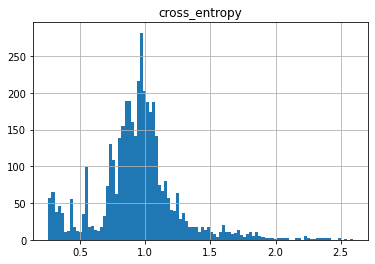

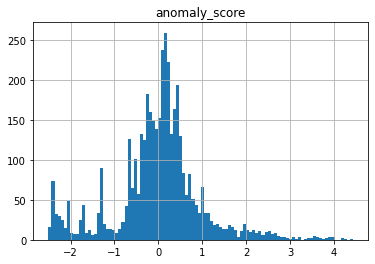

length


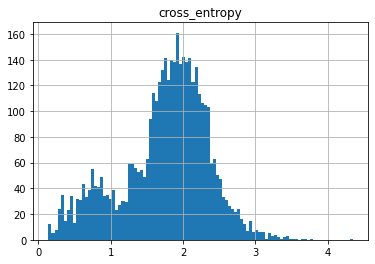

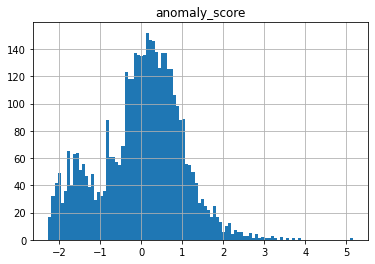

diameter


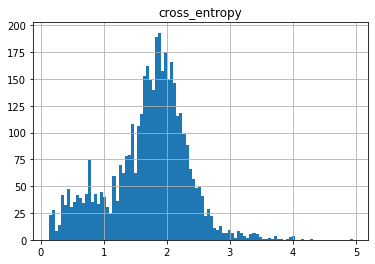

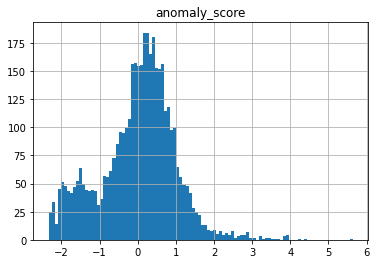

height


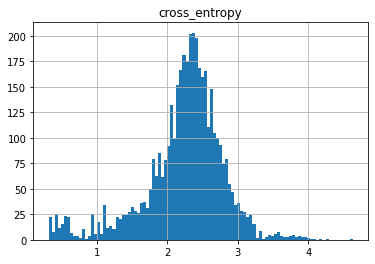

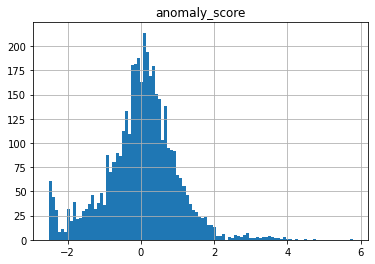

whole_weight


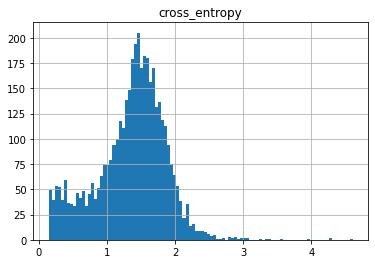

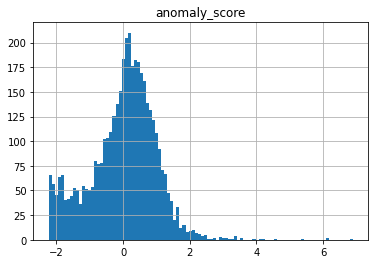

shucked_weight


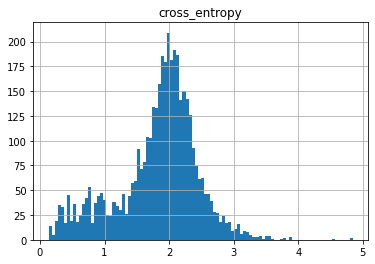

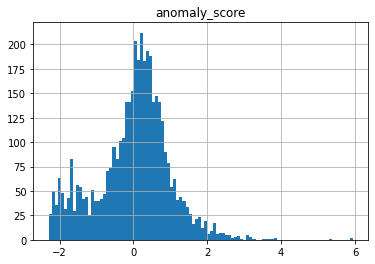

viscera_weight


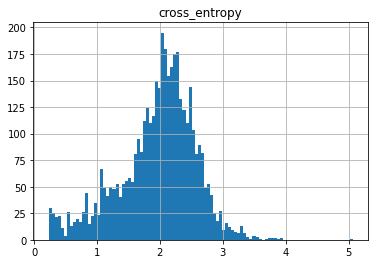

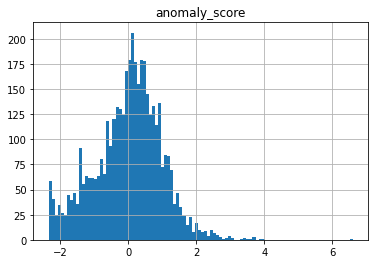

shell_weight


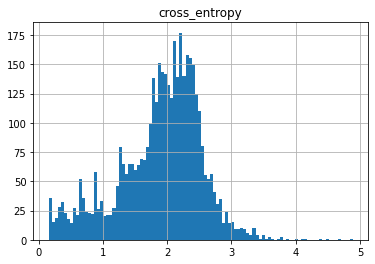

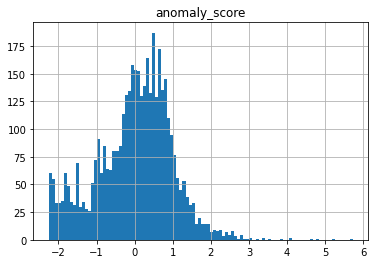

rings


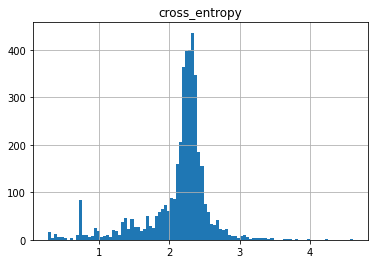

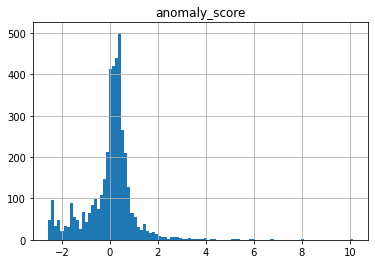

CPU times: user 10min 21s, sys: 1min 44s, total: 12min 6s
Wall time: 1min 30s


In [25]:
%%time

report, fixed_df = make_data_quality_report(abalone, anomaly_thresh=anomaly_thresh, ignore_columns=ignore_columns, plot=True)

# changed value marked as anomaly

In [26]:
len(report['detected_anomalies']['outliers'])

204

In [27]:
## 'index': 90    0.8115 -> 100.0
report['detected_anomalies']['outliers'][:5]

[{'index': 1039,
  'true_label': '(0.999, 6.0]',
  'pred_label': '(10.0, 11.0]',
  'column_name': 'rings',
  'anomaly_score': 10.11964798985039},
 {'index': 1755,
  'true_label': '(6.0, 7.0]',
  'pred_label': '(16.0, 29.0]',
  'column_name': 'rings',
  'anomaly_score': 7.96661350751128},
 {'index': 90,
  'true_label': '(1.701, 100.0]',
  'pred_label': '(0.8, 0.868]',
  'column_name': 'whole_weight',
  'anomaly_score': 6.893479932928596},
 {'index': 2944,
  'true_label': '(6.0, 7.0]',
  'pred_label': '(16.0, 29.0]',
  'column_name': 'rings',
  'anomaly_score': 6.71239071761144},
 {'index': 3593,
  'true_label': '(0.125, 0.14]',
  'pred_label': '(0.298, 0.326]',
  'column_name': 'viscera_weight',
  'anomaly_score': 6.6002492466879845}]

In [28]:
import json

In [29]:
# show report
# print(json.dumps(report, indent=2))

In [30]:
with open('report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

# fix outliers and run again while no outliers left

In [31]:
%%time

changed_values = 0
iteration = 1
while len(report['detected_anomalies']['outliers']) > 0:
    changed_values += len(report['detected_anomalies']['outliers'])
    iteration += 1
    print(f'iteration: {iteration} total_changed_values: {changed_values}')
    report, fixed_df = make_data_quality_report(
        fixed_df, anomaly_thresh=anomaly_thresh, ignore_columns=ignore_columns, plot=False,
        random_state=iteration
    )

iteration: 2 total_changed_values: 204
iteration: 3 total_changed_values: 375
iteration: 4 total_changed_values: 518
iteration: 5 total_changed_values: 650
iteration: 6 total_changed_values: 782
iteration: 7 total_changed_values: 926
iteration: 8 total_changed_values: 1058
iteration: 9 total_changed_values: 1179
iteration: 10 total_changed_values: 1283
iteration: 11 total_changed_values: 1395
iteration: 12 total_changed_values: 1508
iteration: 13 total_changed_values: 1596
iteration: 14 total_changed_values: 1681
iteration: 15 total_changed_values: 1766
iteration: 16 total_changed_values: 1855
iteration: 17 total_changed_values: 1960
iteration: 18 total_changed_values: 2063
iteration: 19 total_changed_values: 2176
iteration: 20 total_changed_values: 2281
iteration: 21 total_changed_values: 2386
iteration: 22 total_changed_values: 2456
iteration: 23 total_changed_values: 2523
iteration: 24 total_changed_values: 2606
iteration: 25 total_changed_values: 2653
iteration: 26 total_changed_va

KeyboardInterrupt: 

## process looks infinite, at least with 3.0 sigma threshold 
### count of changed values bigger than dataset contains

In [32]:
parquet_save(PROCESSED_PATH / 'fixed_dataset', fixed_df)

********** SAVE TO PARQUET FIXED_DATASET **********
size in GB: 0.0005058664828538895
FIXED_DATASET:
head(3):


,index,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,0,I,0.469839,0.364710,0.110385,0.514000,0.224500,0.1010,0.15,7.236357
1,1,I,0.384190,0.277808,0.090000,0.217704,0.099500,0.0485,0.07,7.000000
2,2,M,0.530000,0.403601,0.135917,0.677000,0.290704,0.1415,0.21,9.000000


tail(3):


,index,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
4174,4174,M,0.622465,0.475,0.168099,0.971703,0.477510,0.229375,0.284152,9.0
4175,4175,F,0.625000,0.485,0.166495,1.050482,0.451899,0.237244,0.275300,10.0
4176,4176,M,0.710000,0.555,0.195000,1.948500,0.945500,0.376500,0.495000,12.0


shape: (4177, 10)

saved fixed_dataset to data/processed/fixed_dataset/fixed_dataset.parquet


In [33]:
dt_end = datetime.utcnow()
print(dt_end)
print(f'total execution time: {dt_end - dt_start}')

2023-01-18 16:20:13.547521
total execution time: 11:51:39.943899


In [34]:
fixed_df.to_csv('fixed_dataset', index=False)